# Using Tesla
Spontaneous Magnetization is, [according to the ontology](https://mammos-project.github.io/MagneticMaterialsOntology/doc/magnetic_material_mammos.html#EMMO_032731f8-874d-5efb-9c9d-6dafaa17ef25), in Ampere per meter or equivalent.

Rather than Spontaneous Magnetization, many people actually work with Magnetic Polarization in Tesla. This notebook describes how to adapt a hysteresis loop workflow in Tesla.

In [1]:
import math

import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mammos_mumag import hysteresis
from matplotlib import colormaps

In general, conversion between Tesla and Ampere per meter is not allowed. The following command activates the `magnetic_flux_field` equivalency that allows that conversion.

In [2]:
u.set_enabled_equivalencies(u.magnetic_flux_field())

## Hysteresis simulation

The function `hysteresis.run` requires the Spontaneous Magnetization `Ms` to be defined in Ampere per meter, so we need to convert quantities to Tesla beforehand.

Note that although the conversion is allowed when working with Astropy Quantity, MaMMoS functions still require their inputs to be defined in SI units according to the ontology (i.e., Ampere per meter for Spontaneous Magnetization). For example, `me.Ms(1 * u.T)` will always raise an error. So the correct strategy is to convert the Tesla value to Ampere per meter before calling the `me.Ms()` function.

In [3]:
(1.6 * u.T).to("A/m")  # Convert 1.6 Tesla to A/m

<Quantity 1273239.54404204 A / m>

In [4]:
hysteresis_result = hysteresis.run(
    mesh="cube20_singlegrain_msize2",
    Ms=me.Ms((1.6 * u.T).to("A/m")),
    A=me.A(7.7e-12, unit="J/m"),
    K1=me.Ku(4300000, unit="J/m3"),
    theta=0,
    phi=0,
    h_start=(10 * u.T).to("A/m"),
    h_final=(-10 * u.T).to("A/m"),
    h_n_steps=20,
)

## Hysteresis result object and plotting

The returned `results_hysteresis` contains the following values in Ampere per meter:
- the external field strength `H`
- the spontaneous magnetization value `M` evaluated in the direction of `H`.
- The components of the spontaneous magnetization: `Mx`, `My`, `Mz`.

Let us change the values `H` and `M` to Tesla to produce an updated dataframe and plot them.

In [5]:
B = hysteresis_result.H.q.to("T")  # extract the quantity object from H and convert it to Tesla
J = hysteresis_result.M.q.to("T")  # extract the quantity object from M and convert it to Tesla
Jx = hysteresis_result.Mx.q.to("T")  # x-component of M
Jy = hysteresis_result.My.q.to("T")  # y-component of M
Jz = hysteresis_result.Mz.q.to("T")  # z-component of M

The following cell creates a dataframe `df` with objects in Tesla (when possible).

In [6]:
df = pd.DataFrame(
    {
        "configuration_type": hysteresis_result.configuration_type,
        "B": B,
        "J": J,
        "Jx": Jx,
        "Jy": Jy,
        "Jz": Jz,
        "energy_density": hysteresis_result.energy_density.q,
    }
)
df

,configuration_type,B,J,Jx,Jy,Jz,energy_density
0,1,10.0,1.599863,0.016636,-0.000061,1.599816,-1.672887e+07
1,1,9.0,1.599846,0.015919,-0.000064,1.599811,-1.545575e+07
2,1,8.0,1.599825,0.015106,-0.000069,1.599805,-1.418264e+07
3,1,7.0,1.599800,0.014174,-0.000074,1.599796,-1.290955e+07
4,1,6.0,1.599769,0.013096,-0.000079,1.599784,-1.163648e+07
5,1,5.0,1.599730,0.011835,-0.000086,1.599767,-1.036344e+07
6,1,4.0,1.599680,0.010339,-0.000094,1.599743,-9.090432e+06
7,1,3.0,1.599616,0.008536,-0.000104,1.599710,-7.817471e+06
8,1,2.0,1.599529,0.006322,-0.000115,1.599662,-6.544570e+06
9,1,1.0,1.599409,0.003537,-0.000130,1.599591,-5.271750e+06


Next, we plot the hysteresis loop.

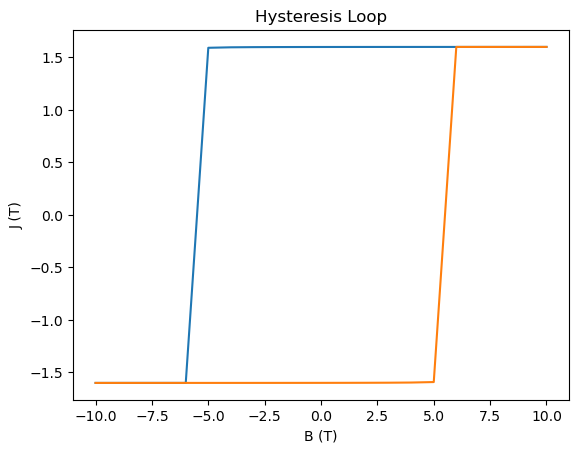

In [7]:
_, ax = plt.subplots()
ax.plot(B, J)
ax.plot(-B, -J)
ax.set_title("Hysteresis Loop")
ax.set_xlabel("B (T)")
ax.set_ylabel("J (T)")

plt.show();

## Saving to csv file
As the `hysteresis.run` function creates a `hystloop.csv` file in `hystloop/`, we want now to create another table with values converted to Tesla.

We choose the following objects from the ontology:
- [`MagneticFluxDensity`](https://w3id.org/emmo#EMMO_961d1aba_f75e_4411_aaa4_457f7516ed6b) (often denoted $\mathbf{B}$) for the external magnetic flux density
- [`MagneticPolarisation`](https://emmo-repo.github.io/emmo.html#EMMO_74a096dd_cc83_4c7e_b704_0541620ff18d) ($\mathbf{J}$) for the magnetic polarization.

In [8]:
B = me.B(value=B, unit="T")
J = me.J(value=J, unit="T")
Jx = me.J(value=Jx, unit="T")
Jy = me.J(value=Jy, unit="T")
Jz = me.J(value=Jz, unit="T")
me.io.entities_to_file(
    "hystloop_Tesla.csv",
    "Hysteresis loop in Tesla",
    B=B,
    J=J,
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
)

## Generate plot of $H_c(T)$ (temperature dependent coercive field)
In this section we show how to generate the plot from [the MaMMoS Hard magnet tutorial](https://mammos-project.github.io/mammos/examples/workflows/hard-magnet-tutorial.html#Compute-Hc(T)) using Celsius and Tesla

In [9]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Fe16N2")
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Fe16N2")
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 7)

simulations = []
for temperature in T:
    print(f"Running simulation for T={temperature:.0f}")
    results_hysteresis = hysteresis.run(
        mesh="cube20_singlegrain_msize2",
        Ms=results_kuzmin.Ms(temperature),
        A=results_kuzmin.A(temperature),
        K1=results_kuzmin.K1(temperature),
        theta=0,
        phi=0,
        h_start=(1.5 * u.T).to(u.A / u.m),
        h_final=(-1.5 * u.T).to(u.A / u.m),
        h_n_steps=20,
    )
    simulations.append(results_hysteresis)

Running simulation for T=0 K
Running simulation for T=215 K
Running simulation for T=430 K
Running simulation for T=645 K
Running simulation for T=859 K
Running simulation for T=1074 K
Running simulation for T=1289 K


Let us visualize $H_c(T)$, expressing the temperature Celsius and the coercive field in Tesla. For this, we need to activate the `temperature` equivalency on top of the previously enabled equivalencies.

In [10]:
u.add_enabled_equivalencies(u.temperature())

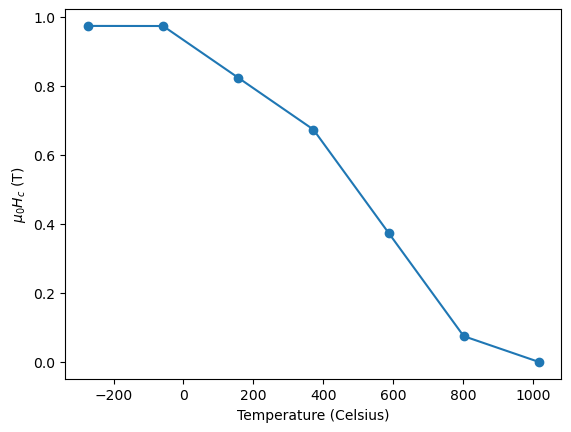

In [11]:
T_C = T.to("Celsius").value
Hcs_Am = []
for res in simulations:
    cf = mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).q
    if np.isnan(cf):  # Above Tc
        cf = me.Hc(0).q
    Hcs_Am.append(cf)  # values in A/m
Hcs_T = me.Hc(Hcs_Am).q.to("T")  # values in T
plt.plot(T_C, Hcs_T, linestyle="-", marker="o")
plt.xlabel("Temperature (Celsius)")
plt.ylabel("$\mu_0 H_c$ (T)")
colors = colormaps["plasma"].colors[:: math.ceil(256 / len(T))]

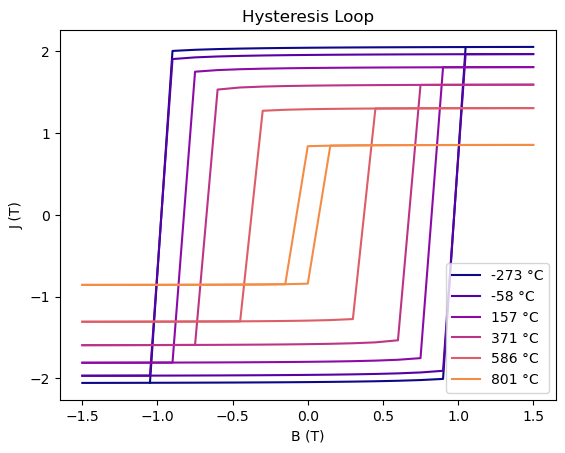

In [12]:
fix, ax = plt.subplots()
for temperature, sim, color in zip(T_C, simulations, colors, strict=False):
    if np.isnan(sim.M.q).all():  # no Ms above Tc
        continue
    B = sim.H.q.to("T")
    J = sim.M.q.to("T")
    ax.plot(B, J, label=f"{temperature:.0f} °C", color=color)
    ax.plot(-B, -J, color=color)
    ax.set_title("Hysteresis Loop")
    ax.set_xlabel("B (T)")
    ax.set_ylabel("J (T)")
ax.legend(loc="lower right");